# TPGMM Example — PyTorch Backend

This notebook demonstrates the Task Parameterized Gaussian Mixture Model and
Gaussian Mixture Regression using the **PyTorch** backend.

Install dependencies with:
```bash
pip install tpgmm[torch,examples]
# or with uv:
uv sync --extra torch --extra examples
```

## 1. Imports

In [1]:
import sys
sys.path.append('..')

In [2]:
import numpy as np
import torch

from tpgmm.torch import TPGMM, GaussianMixtureRegression
from tpgmm.utils.plot.plot import plot_trajectories, plot_ellipsoids, scatter

## 2. Generate synthetic trajectory data

We create a synthetic 3D trajectory and generate noisy variations of it.

In [3]:
np.random.seed(42)
torch.manual_seed(42)

# Base trajectory: a smooth curve in 3D
t = np.linspace(0, 2 * np.pi, 50)
base_trajectory = np.column_stack([np.cos(t), np.sin(t), t / (2 * np.pi)])

# Generate noisy demo trajectories
num_demos = 30
trajectories = []
for _ in range(num_demos):
    noise = np.random.normal(0, 0.02, size=base_trajectory.shape)
    trajectories.append(base_trajectory + noise)

trajectories = np.array(trajectories)
print(f"Generated {num_demos} demo trajectories with shape: {trajectories.shape}")

Generated 30 demo trajectories with shape: (30, 50, 3)


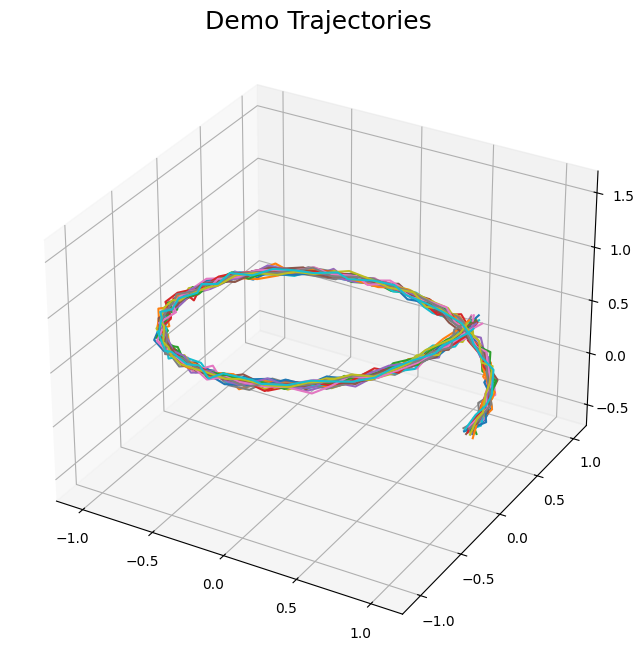

(<Figure size 1000x800 with 1 Axes>,
 <Axes3D: title={'center': 'Demo Trajectories'}>)

In [4]:
plot_trajectories(title="Demo Trajectories", trajectories=trajectories, show=True)

## 3. Transform into local reference frames

Transform trajectories into start and end reference frames.

In [5]:
from tpgmm.utils.geometry import transform_into_frames

translations = np.stack([
    np.stack([-traj[0], -traj[-1]]) for traj in trajectories
])
rotations = np.tile(np.eye(3), (num_demos, 2, 1, 1))

local_trajectories = transform_into_frames(trajectories, translations, rotations)
print(f"Local trajectories shape: {local_trajectories.shape}")

Local trajectories shape: (30, 2, 50, 3)


## 4. Add time dimension and prepare data

In [6]:
num_points = local_trajectories.shape[2]
time_vec = np.linspace(0, 1, num_points)[:, None]

local_with_time = []
for demo in local_trajectories:
    frames_with_time = []
    for frame in demo:
        frames_with_time.append(np.concatenate([frame, time_vec], axis=-1))
    local_with_time.append(np.array(frames_with_time))

local_with_time = np.array(local_with_time)

# Concatenate all demos
concat_data = np.concatenate(local_with_time, axis=1)
concat_tensor = torch.from_numpy(concat_data)
print(f"Concatenated data shape: {concat_tensor.shape}")

Concatenated data shape: torch.Size([2, 1500, 4])


## 5. Fit TPGMM (PyTorch backend)

Train the task-parameterized Gaussian mixture model using EM.

In [7]:
n_components = 8
tpgmm = TPGMM(n_components=n_components, verbose=True)
tpgmm.fit(concat_tensor)

print(f"\nWeights: {tpgmm.weights_}")
print(f"Means shape: {tpgmm.means_.shape}")
print(f"Covariances shape: {tpgmm.covariances_.shape}")

Started KMeans clustering
finished KMeans clustering
Start expectation maximization
Log likelihood: 4928.39697265625 improvement 21498.27392578125
Log likelihood: 11134.9970703125 improvement 6206.60009765625
Log likelihood: 14531.7578125 improvement 3396.7607421875
Log likelihood: 14740.5419921875 improvement 208.7841796875
Log likelihood: 14889.46875 improvement 148.9267578125
Log likelihood: 15058.638671875 improvement 169.169921875
Log likelihood: 15102.259765625 improvement 43.62109375
Log likelihood: 15217.4189453125 improvement 115.1591796875
Log likelihood: 15282.0732421875 improvement 64.654296875
Log likelihood: 15325.154296875 improvement 43.0810546875
Log likelihood: 15459.3076171875 improvement 134.1533203125
Log likelihood: 15570.693359375 improvement 111.3857421875
Log likelihood: 15598.25 improvement 27.556640625
Log likelihood: 15617.4482421875 improvement 19.1982421875
Log likelihood: 15700.759765625 improvement 83.3115234375
Log likelihood: 15826.1943359375 improveme

## 6. Visualize fitted GMM components

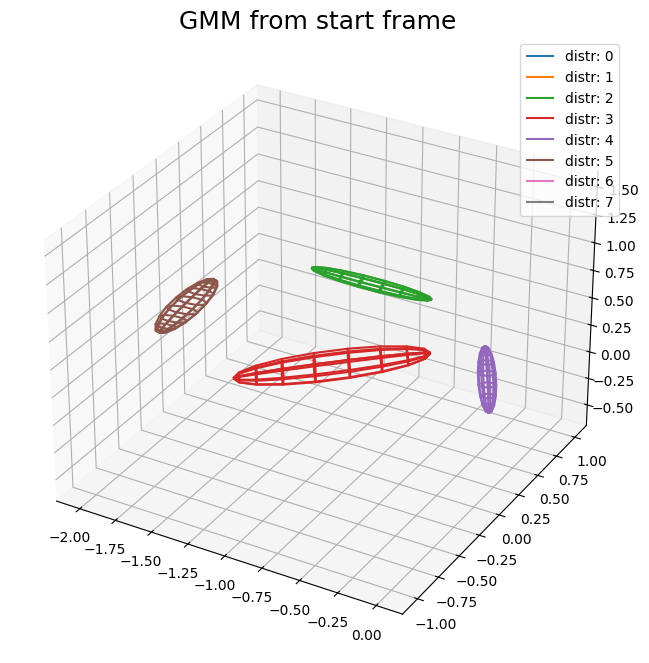

(<Figure size 1000x800 with 1 Axes>,
 <Axes3D: title={'center': 'GMM from start frame'}>)

In [8]:
frame_idx = 0
plot_ellipsoids(
    title="GMM from start frame",
    means=tpgmm.means_[frame_idx, :, :3].numpy(),
    covs=tpgmm.covariances_[frame_idx, :, :3, :3].numpy(),
    legend=True,
    show=True,
)

## 7. Model selection via BIC

100%|██████████| 12/12 [00:02<00:00,  4.18it/s]


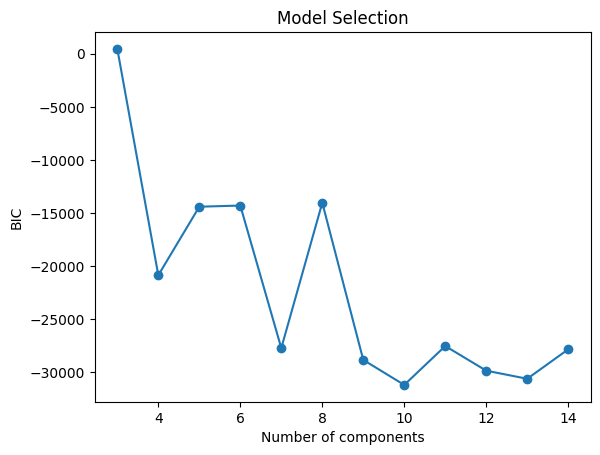

In [9]:
from tqdm import tqdm
import matplotlib.pyplot as plt

K = np.arange(3, 15)
bic_scores = []
for k in tqdm(K):
    model = TPGMM(n_components=k, reg_factor=1e-3)
    model.fit(concat_tensor)
    bic_scores.append(model.bic(concat_tensor))

fig, ax = plt.subplots()
ax.plot(K, bic_scores, marker="o")
ax.set_xlabel("Number of components")
ax.set_ylabel("BIC")
ax.set_title("Model Selection")
plt.show()

## 8. Gaussian Mixture Regression

Use the PyTorch GMR to reconstruct a trajectory for new start/end positions.

In [10]:
gmr = GaussianMixtureRegression.from_tpgmm(tpgmm, input_idx=[3])

translation = torch.tensor([trajectories[0][0], trajectories[0][-1]], dtype=torch.float32)
rotation_matrix = torch.eye(3).unsqueeze(0).expand(2, -1, -1)
gmr.fit(translation=translation, rotation_matrix=rotation_matrix)

input_data = torch.linspace(0, 1, 100).unsqueeze(1)
mu, cov = gmr.predict(input_data)
print(f"Predicted mean shape: {mu.shape}, covariance shape: {cov.shape}")

Predicted mean shape: torch.Size([100, 3]), covariance shape: torch.Size([100, 3, 3])


/tmp/ipykernel_151816/1762446249.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  translation = torch.tensor([trajectories[0][0], trajectories[0][-1]], dtype=torch.float32)


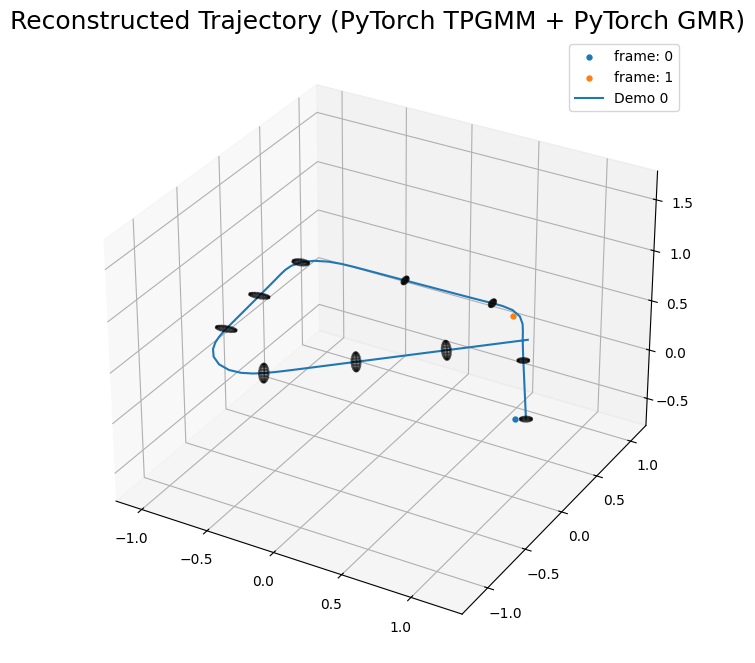

Distance to start: 0.0700
Distance to end: 0.3158


In [11]:
mu_np = mu.detach().numpy()
cov_np = cov.detach().numpy()
translation_np = translation.numpy()

fig, ax = scatter(title="Reconstructed Trajectory (PyTorch TPGMM + PyTorch GMR)", data=translation_np[:, None])
fig, ax = plot_trajectories(trajectories=mu_np[None], fig=fig, ax=ax, legend=True)
plot_ellipsoids(means=mu_np[::10], covs=cov_np[::10], fig=fig, ax=ax, color="k", alpha=0.3, show=True)

print(f"Distance to start: {np.linalg.norm(translation_np[0] - mu_np[0]):.4f}")
print(f"Distance to end: {np.linalg.norm(translation_np[1] - mu_np[-1]):.4f}")